#**Case Study: License Plate Detection**

#**All General Imports**

In [54]:
import cv2
import os
import sys
import timeit
import platform
import numpy as np
from imutils import paths
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow

#**All Tensorflow-Keras Imports**

In [55]:
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, Dropout, Input 
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

#**All Initializations**

In [56]:
np.random.seed(42)
default_callbacks = []

#**All Globals**

In [57]:
rescale = True
input_size = 80
limit = 10000
n_image_to_show = 1
summary = True
log = True

#**All Hyperparameters**

In [58]:
shuffle = True
imagenet_init_weights = True
early_stopping = True
train_all_layers = True
epochs_number = 30
learning_rate = 0.0001
valid_set_perc = 0.1
test_set_perc = 0.1
train_batch_size = 64
test_batch_size = 512
save_best_model = True
data_augmentation = True

#**All Functions Definitions**

In [59]:
def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

#**Mounting Google Drive via Code**

In [60]:
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Data Download**

The **EMNIST** (Extended MNIST) dataset is a set of **handwritten** character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset. In this project, we use EMNIST tro train the **Licence Plate OCR** Models. 

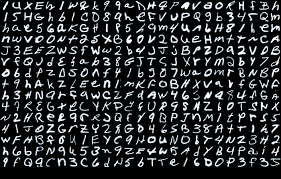

In [61]:
start_time = timeit.default_timer()
# Operating System
OS = platform.system()                           # returns 'Windows', 'Linux', etc

os.system('pip install --upgrade --no-cache-dir gdown')

out = data_download("./semantic_drone_dataset_small.zip", "1g6DkPfteftA_GU6WKyaLhT-qw83tkkxf", OS)

print("Elapsed Time: ", timeit.default_timer() - start_time)

Elapsed Time:  3.30856174500002


#**Preprocessing**

#**Data Loading**

In [62]:
print("\nLoading Characters Dataset from the Local Drive...")
load_start_time = timeit.default_timer()
image_paths = list(paths.list_images('/content/dataset_characters'))  # Fetch the image paths from the folder path

count = {}
data_set = []
labels = []
for image_path in image_paths: 
  label = image_path.split(os.path.sep)[-2]

  # Verify if there is the label as key in the dict otherwise it creats it
  occ = count.get(label, 0)
  if occ == 0: 
    count.update({label : 1})
  else: 
    if count[label] <= limit: 
      count[label] += 1
  
  if count[label] <= limit: 
    # load the image by Open CV
    image = cv2.imread(image_path)

    if count[label] <= n_image_to_show: 
      cv2_imshow(image)

    if rescale == True: 
      image = cv2.resize(image, (input_size, input_size))

    image = img_to_array(image)

    data_set.append(image)
    labels.append(label)

data_set = np.array(data_set, dtype='float16')
labels = np.array(labels)

exec_time = (timeit.default_timer() - load_start_time) / 60.0
print("\n\nLoading time: %.2f minutes\n" % (exec_time))

n_channels = data_set.shape[3]
n_classes = len(np.unique(labels))



Loading Characters Dataset from the Local Drive...




Loading time: 0.28 minutes



#**Shuffle everything**


In [63]:
if shuffle == True: 
  indices = np.arange(data_set.shape[0])
  np.random.shuffle(indices)

  data_set = data_set[indices]
  labels = labels[indices]

#**Encode Labels**

In [64]:
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)

#**Labels Saving**

Save label file so we can use it in another script


In [65]:
np.save('/content/drive/MyDrive/DL_Models/lp_labels.npy', lb.classes_)

#**Train-Val-Test Split**

In [66]:
num_validation_samples = int(round(valid_set_perc * data_set.shape[0]))
num_test_samples = int(round(test_set_perc * data_set.shape[0]))
train_set_x = data_set[:-(num_test_samples + num_validation_samples)]
train_set_y = labels[:-(num_test_samples + num_validation_samples)]
val_set_x = data_set[-(num_test_samples + num_validation_samples):-num_test_samples]
val_set_y = labels[-(num_test_samples + num_validation_samples):-num_test_samples]
test_set_x = data_set[-num_test_samples:]
test_set_y = labels[-num_test_samples:]

#**Normalization**


In [67]:
train_set_x /= 255
val_set_x /= 255
test_set_x /= 255

#**One-hot encoding**

In [68]:
train_set_y = to_categorical(train_set_y, num_classes = n_classes)
val_set_y = to_categorical(val_set_y, num_classes = n_classes)
test_set_y = to_categorical(test_set_y, num_classes = n_classes)

#**Data Augmentation**

In [69]:
if data_augmentation == True:
  image_gen = ImageDataGenerator(rotation_range = 10, 
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 shear_range = 0.1,
                                 zoom_range = 0.1,
                                 fill_mode = 'nearest')


#**Sanity Checks**

In [70]:
print(image_paths)
print(len(image_paths))
print(len(labels))
print(count)
print(data_set.shape)
print(train_set_x.shape)
print(val_set_x.shape)
print(test_set_x.shape)
print(test_set_y)

['/content/dataset_characters/3/3_155.jpg', '/content/dataset_characters/3/3_105.jpg', '/content/dataset_characters/3/3_38.jpg', '/content/dataset_characters/3/3_375.jpg', '/content/dataset_characters/3/3_226.jpg', '/content/dataset_characters/3/3_276.jpg', '/content/dataset_characters/3/3_239.jpg', '/content/dataset_characters/3/3_611.jpg', '/content/dataset_characters/3/3_896.jpg', '/content/dataset_characters/3/3_231.jpg', '/content/dataset_characters/3/3_530.jpg', '/content/dataset_characters/3/3_394.jpg', '/content/dataset_characters/3/3_784.jpg', '/content/dataset_characters/3/3_967.jpg', '/content/dataset_characters/3/3_848.jpg', '/content/dataset_characters/3/3_62.jpg', '/content/dataset_characters/3/3_865.jpg', '/content/dataset_characters/3/3_284.jpg', '/content/dataset_characters/3/3_223.jpg', '/content/dataset_characters/3/3_796.jpg', '/content/dataset_characters/3/3_565.jpg', '/content/dataset_characters/3/3_874.jpg', '/content/dataset_characters/3/3_395.jpg', '/content/da

#**OCR (Object Character Recognition) Model Definition**

In [71]:
# Selecting whether to adopt transfer learning or not
if imagenet_init_weights == True: 
  pretrained_weights = 'imagenet'
else: 
  pretrained_weights = None

model_input_height = input_size
model_input_width = input_size 

input_tensor = Input(shape = (model_input_width, model_input_height, n_channels))
deep_network = MobileNetV2(weights = pretrained_weights, include_top = False, input_tensor = input_tensor)

top_model = deep_network.output
top_model = AveragePooling2D(pool_size = (3, 3))(top_model)
top_model = Flatten(name = "flatten")(top_model)
top_model = Dense(128, activation = "relu")(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(n_classes, activation = "softmax")(top_model)

deep_model = Model(inputs=deep_network.input, outputs=top_model)

# train all layers
if train_all_layers == True: 
  for layer in deep_network.layers: 
    layer.trainable = True

if summary == True: 
  deep_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

#**Callbacks Definition**

When we training a neural network, the **learning rate** tuning is often the most important hyperparameter:

1) Too small a learning rate and your neural network may not learn at all

2) Too large a learning rate and you may overshoot areas of low loss (or even overfit from the start of training)

Here we initialize **ADAM** optimizer with an initial learning rate (**learning_rate**). We then set our decay to be the learning rate divided by the total number of epochs we are training the network for (a common rule of thumb).

Internally, Keras applies the following learning rate schedule to adjust the learning rate after every batch update. Update formula is: 


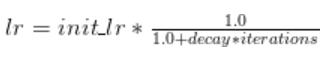

Example: 

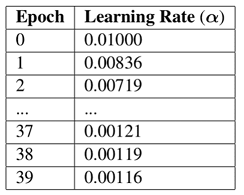

In [72]:
print("Training mode is starting...")

opt = Adam(lr = learning_rate, decay = learning_rate / epochs_number)

deep_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

if log == True: 
  csv_logger = CSVLogger('./history.log')
  default_callbacks = default_callbacks + [csv_logger]

if save_best_model == True:
  check_point = ModelCheckpoint('/content/drive/MyDrive/DL_Models/mobilenet.h5', save_weights_only = True, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
  default_callbacks = default_callbacks + [check_point]

if early_stopping == True: 
  earlyStopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5, verbose = 0, mode = 'min')
  default_callbacks = default_callbacks + [earlyStopping]


Training mode is starting...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#**OCR Model Training**

In [73]:
if data_augmentation == False:
  history = deep_model.fit(train_set_x, train_set_y, batch_size = train_batch_size, epochs = epochs_number, validation_data = (val_set_x, val_set_y), callbacks = default_callbacks, verbose = 2)
else: 
  steps_per_epoch = len(train_set_x) / train_batch_size
  history = deep_model.fit_generator(image_gen.flow(train_set_x, train_set_y, batch_size = train_batch_size), steps_per_epoch = steps_per_epoch, epochs = epochs_number, validation_data = (val_set_x, val_set_y), callbacks = default_callbacks, verbose = 2)


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """



Epoch 1: val_accuracy improved from -inf to 0.29878, saving model to /content/drive/MyDrive/DL_Models/mobilenet.h5
470/470 - 82s - loss: 1.6457 - accuracy: 0.5674 - val_loss: 3.0929 - val_accuracy: 0.2988 - 82s/epoch - 174ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.29878 to 0.68767, saving model to /content/drive/MyDrive/DL_Models/mobilenet.h5
470/470 - 73s - loss: 0.4774 - accuracy: 0.8711 - val_loss: 1.1747 - val_accuracy: 0.6877 - 73s/epoch - 156ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.68767 to 0.82616, saving model to /content/drive/MyDrive/DL_Models/mobilenet.h5
470/470 - 74s - loss: 0.3217 - accuracy: 0.9130 - val_loss: 0.6069 - val_accuracy: 0.8262 - 74s/epoch - 158ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.82616 to 0.88543, saving model to /content/drive/MyDrive/DL_Models/mobilenet.h5
470/470 - 74s - loss: 0.2526 - accuracy: 0.9290 - val_loss: 0.3949 - val_accuracy: 0.8854 - 74s/epoch - 156ms/step
Epoch 5/30

Epoch 5: val_accuracy 

#**Model Architecture Saving**

In [74]:
model_json = deep_model.to_json()
with open('/content/drive/MyDrive/DL_Models/mobilenet.json', "w") as json_file: 
  json_file.write(model_json) 

#**Model Evaluation**

In [75]:
score = deep_model.evaluate(test_set_x, test_set_y, batch_size = test_batch_size)
print(score)

8/8 [==============================] - 3s 267ms/step - loss: 0.0780 - accuracy: 0.9777
[0.0779966413974762, 0.9776714444160461]
